In [7]:
import numpy as np
import matplotlib.pyplot as plt
import lightkurve as lk

from timeseriestools import map_and_interpolate_gaps, remove_nans, sigma_clip
from acf_mma import acf_mma

%matplotlib ipympl
%load_ext autoreload
%autoreload 2

First let's acquire a Kepler light curve. As an example we'll use several quarters from KIC 2832175, but we could also try any other one from McQuillan's catalog.

In [8]:
lc = lk.search_lightcurve('kplr002832175', mission='Kepler', cadence=1800)[5:10].download_all().stitch()

In [9]:
t = np.array(lc.time.value) # lc.time contains an array of astropy.Time objects, but we only want the value of the time
y = np.array(np.float64(lc.flux))
t, y = remove_nans(t, y, verbose=True)
y = (y/np.median(y) - 1 ) * 1000 # convert y to ppt

remove_nans: Removed 30/20683≈0.1% nan values from original data


In order to use the ACF, we have to make sure our data is evenly spaced. Let's linearly interpolate small gaps in data (e.g. Δt < 10 days) while filling the rest with 0, i.e., constant flux, so that they don't influence the ACF as poorly as if we were to interpolate. 

In [10]:
t, y = sigma_clip(t, y, sigma=5, verbose=True)
t_mapped, y_mapped = map_and_interpolate_gaps(t, y, fill_large_gaps=True, min_gap_size=10, fill_value=0)

sigma_clip: 5σ clipped 7/20653≈0.0% of the unmasked data


Here we'll plot the mapped light curve. This system displays clear activity, and visually there appears to be a rotation period of either 10 or 20 days.

If you zoom in, you can see small gaps where the flux was interpolated. The gap from around days 720–735 was instead filled with a horizontal line.

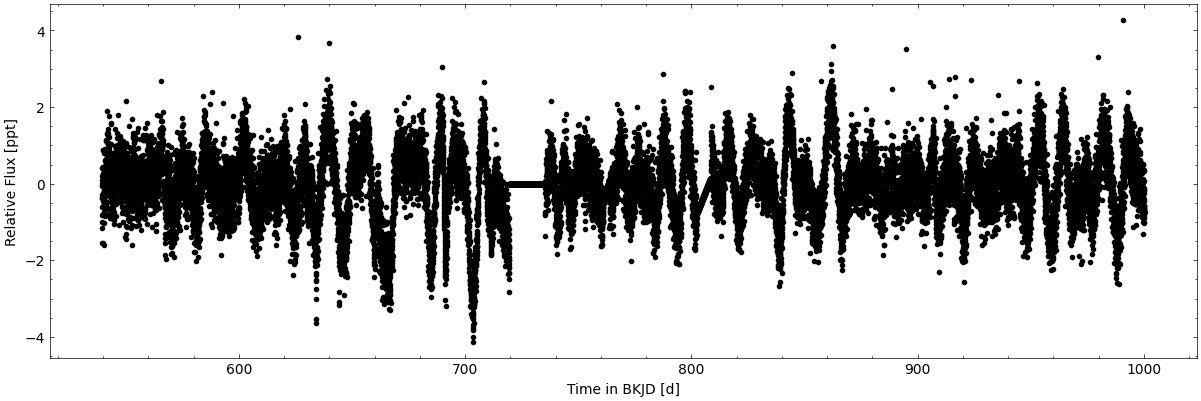

In [11]:
fig, ax = plt.subplots(figsize=(12, 4), constrained_layout=True)

ax.set_xlabel('Time in BKJD [d]')
ax.set_ylabel('Relative Flux [ppt]')
ax.scatter(t_mapped, y_mapped)

We can now run the McQuillan ACF. 

Let's ensure our peak is significant by enforcing that the local peak height is above 0.1. If the algorithm can't find any peaks larger than 0.1, it's likely that we either oversmoothed or undersmoothed the ACF, so it will automatically try again with different smoothing. If nothing works, the algorithm is indeterminate

acf_mma: Dominant period: 18.57412441255292
acf_mma: Peaks that are harmonics of dominant period: [18.57412441255292, 37.65908833040157, 55.00719793024473, 73.80609172512777]
acf_mma: P_rot = 18.404525696794735±0.14477111066458995
Smoothing: default


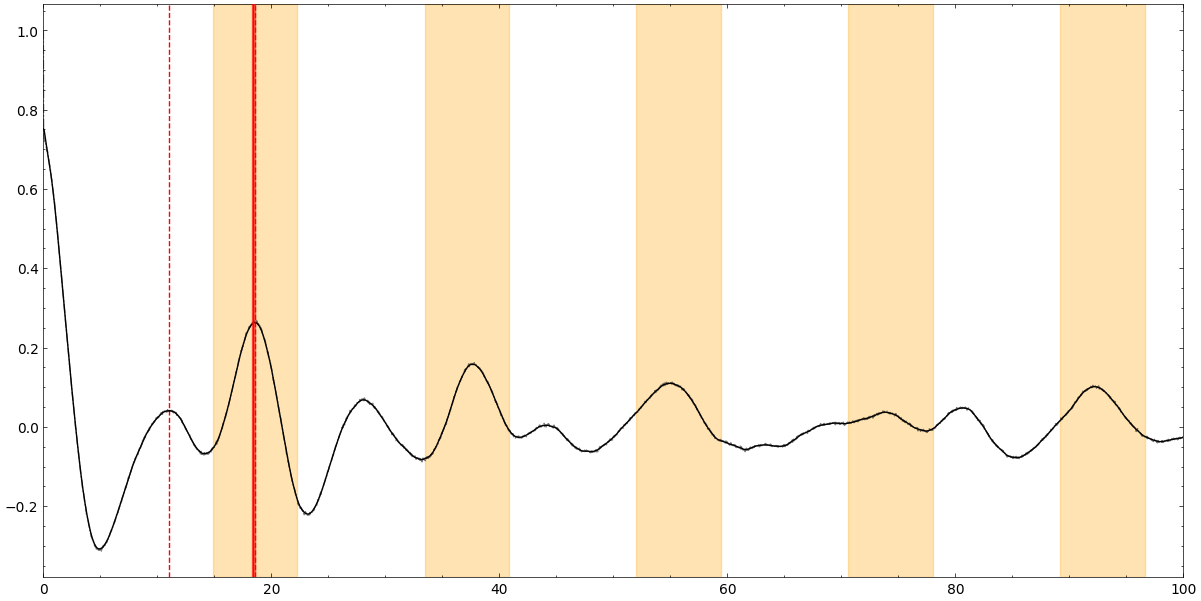

In [12]:
(P_rot, P_rot_err), flag = acf_mma(t_mapped, y_mapped, min_lph = 0.1, plot=True, verbose=True, version=2014)
plt.xlim(0, 100)
print(f'Smoothing: {flag}')

Nice! It turns out the the dominant period is roughly 18.5. At around half the period, there is also a peak, but the second peak has a higher local peak height. Physically, this can occur when the star has two dominant active regions on opposite hemispheres of the star, i.e., you'll obtain two oscillations per rotation.